Libraries and Style Files
-------------------------

In [1]:
from pathlib import Path
import sys
import importlib

# Notebook working directory and set up file paths
NOTEBOOK_DIR = Path.cwd()    
TOP_DIR = NOTEBOOK_DIR.parent
LIB_DIR = TOP_DIR / "python"
DATA_DIR = TOP_DIR/'data_files'

# Add python library folder to sys.path
if str(LIB_DIR) not in sys.path:
    sys.path.insert(0, str(LIB_DIR))

# Import Libraries
import ENDF6el as endfel
import shielding as sh
import ENDF6
import flux_recoil_spec as frs

# remove when done editing shielding lib
importlib.reload(sh)
importlib.reload(frs)

from matplotlib import pyplot as plt
plt.style.use(str(TOP_DIR/"mplstyles"/"stylelib"/"standard.mplstyle"))  

# Computational libraries
import numpy as np
import scipy
import scipy.integrate as integrate


SNOLAB Flux from Slab Source Calculations
=========================================

In the notebook `B-SOURCES4A-Running.ipynb` in this directory we figured out how many neutrons were produced per volume per second of shotcrete--the material that surrounds the SNOLAB cavern. In order to calculate the ambient neutron flux (in units of neutrons/cm$^2$/s), however, we must combine this knowledge with some basic neutron transport.  

Volume Sources to Calculate Cavern Neutron Flux
-----------------------------------------------

 [[This article on rectangular volume source approximations][Wallace1993]] provides a way to estimate ambient neutron flux while considering shielding surrounding the SNOLAB cavern. We treat neutrons the same as gamma particles in terms of flux sources. The formulas used in these articles (primarily focused on gamma flux in particular) can be adapted for neutrons by replacing the absorption coefficient with the attenuation factor, or total macroscopic cross section instead of absorption cross section, ignoring multiple scattering.

 [[Semi-Analytic Flux Formulas for Shielding Calculations][semianalytic]] outlines the formulas for determining flux based on shielding geometries. For our purposes of estimating cavern flux from the shotcrete walls at SNOLAB, the neutron source can be modelled as a rectangular volume source with an exterior detector point (page 119).

For the cavern walls, the neutron source is only self-shielding. Without extra shielding, ($\mu=\mu_c=0$), the un-scattered flux in this geometric configuration is:

$\Phi_{un}=\frac{S_v}{4\pi\mu_s}\int_{0}^{\phi_1}d\phi\int_0^{\theta_1}d\theta\space cos\theta[1-e^{-\mu_{s} l_{3}\space sec\phi \space sec\theta}]$

$+\frac{S_v}{4\pi\mu_s}\int_{\phi_1}^{\phi_2}d\phi\int_{0}^{\theta_1}d\theta \space cos\theta[1-e^{-\mu_{s}[l_1\space cot\phi-a]sec\phi \space sec\theta}]$

$+\frac{S_v}{4\pi\mu_s}\int_{0}^{\phi_1}d\phi\int_{\theta_1}^{\theta_2}d\theta\space cos\theta[1-e^{-\mu_{s}[l_{2}\space cot\theta -a]sec\phi\space sec\theta}]$

$+\frac{S_v}{4\pi\mu_s}\int_{\phi_1}^{\phi_2}d\phi\int_{\theta_1}^{\theta_3}d\theta\space cos\theta[1-e^{-\mu_{s}[l_{1}\space cot\theta -a]sec\phi\space sec\theta}]$

Where:

$\phi_1\equiv tan^{-1}\frac{l_1}{a+l_3}$

$\theta_1\equiv tan^{-1}\frac{l_2}{(a+l_3)sec\phi}$

$\phi_2\equiv tan^{-1}\frac{l_1}{a}$

$\theta_2\equiv tan^{-1}\frac{l_2}{a\space sec\phi}$

$\theta_3\equiv tan^{-1}\frac{l_2}{l_1\space csc\phi}$


[Wallace1993]:https://digital.library.unt.edu/ark:/67531/metadc1402448/ "An approximate algorithm for the flux from a rectangular volume source"
[semianalytic]:https://digital.library.unt.edu/ark:/67531/metadc1450446/ "Semi-analytic flux formulas for shielding calculations"

In [2]:
shotcrete_source= frs.SNOLAB_shotcrete_source()
En=shotcrete_source['E']

f = open(str(TOP_DIR/'data_files'/'xn_data'/'n-014_Si_028.endf'))
lines = f.readlines()
sec = ENDF6.find_section(lines, MF=4, MT=2)



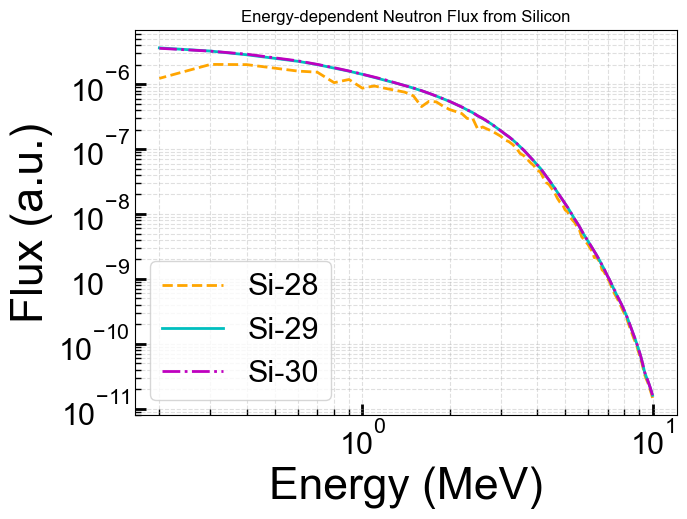

In [3]:
#from sh import Edep28
a=1
l1=2
l2=2
l3=2

plt.figure(figsize=(7,5))
plt.plot(En, shotcrete_source['tot']*sh.Edep28(a,l1,l2,l3,En), label="Si-28", color="orange", linestyle = "--")
plt.plot(En, shotcrete_source['tot']*sh.Edep29(a,l1,l2,l3,En), label="Si-29", color ="c")
plt.plot(En, shotcrete_source['tot']*sh.Edep30(a,l1,l2,l3,En), label="Si-30", color="m", linestyle = "-.")


plt.xscale("log")      
plt.yscale("log") 
#plt.ylim(10e-5, 1)
#plt.xlim(1e-4,10)
plt.xlabel("Energy (MeV)")
plt.ylabel("Flux (a.u.)")
plt.title("Energy-dependent Neutron Flux with Silicon Shielding")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.legend()


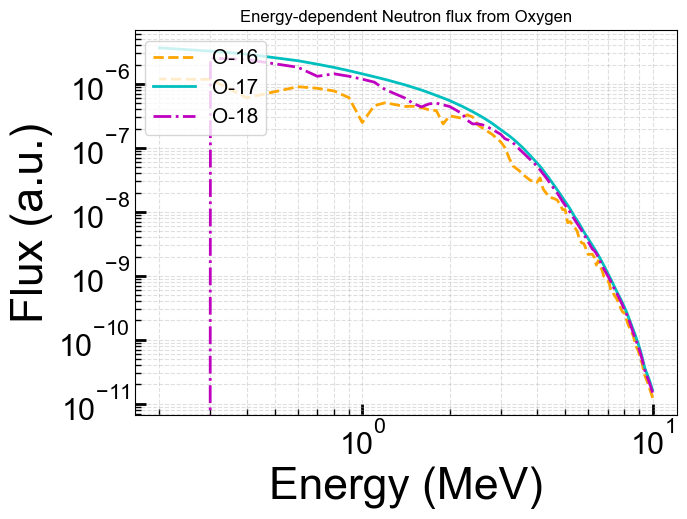

In [4]:
plt.figure(figsize=(7,5))
plt.plot(En, shotcrete_source['tot']* sh.Edep16(a,l1,l2,l3,En), label="O-16", color="orange", linestyle="--")
plt.plot(En, shotcrete_source['tot']*sh.Edep17(a,l1,l2,l3,En), label="O-17", color ="c")
plt.plot(En, shotcrete_source['tot']*sh.Edep18(a,l1,l2,l3,En), label="O-18", color ="m", linestyle="-.")

plt.xscale("log")  
plt.yscale("log")
#plt.xlim(1e-4,10)
plt.xlabel("Energy (MeV)")
plt.ylabel("Flux (a.u.)")
plt.title("Energy-dependent Neutron flux with Oxygen Shielding")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.legend(loc=2, fontsize=15)

Text(0.5, 0, 'Energy (eV)')

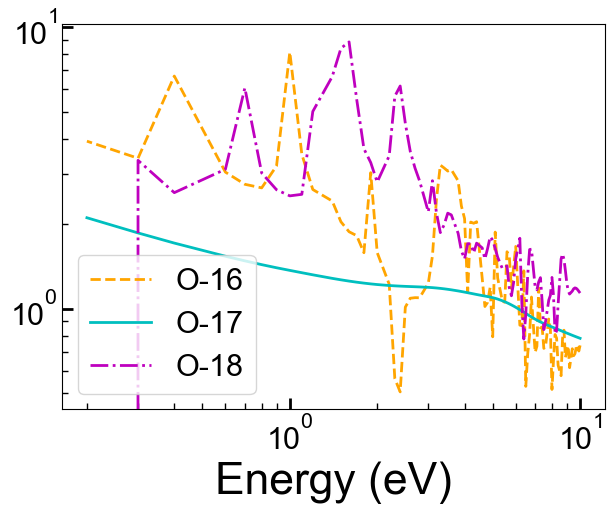

In [5]:
plt.figure(figsize=(7,5))
f16=endfel.fetch_elastic(filename=str(DATA_DIR/'xn_data'/'o16_el.txt'))
f17=endfel.fetch_elastic(filename=str(DATA_DIR/'xn_data'/'o17_el.txt'))
f18=endfel.fetch_elastic(filename=str(DATA_DIR/'xn_data'/'o18_el.txt'))

plt.plot(En, f16(En), label="O-16", color="orange", linestyle="--")
plt.plot(En, f17(En), label="O-17", color ="c")
plt.plot(En, f18(En), label="O-18", color ="m", linestyle="-.")

plt.xscale("log")  
plt.yscale("log")
plt.legend()
#plt.xlim(1e-4,10)
plt.xlabel("Energy (eV)")

Norite Slab Source and Shielding
--------------------------------

https://www.sciencedirect.com/science/article/pii/S0169136825001453?ref=pdf_download&fr=RR-2&rr=9ba7230479e5b3ad
